# Decision Tree

In [1]:
from __future__ import division
from collections import Counter
import json
import numpy as np
import pandas as pd

In [2]:
urgent   = ['urgent', 'urgent', 'near', 'none', 'none', 'none', 'near', 'near', 'near', 'urgent']
lazy     = ['yes', 'yes', 'yes', 'no', 'yes', 'no', 'no', 'yes', 'yes', 'no']
outcomes = ['party', 'study', 'party', 'party', 'pub', 'party', 'study', 'tv', 'party', 'study']

# dataset = np.column_stack((urgent, lazy, classes))
# dataset = np.array([tuple(l) for l in dataset],
#                    dtype=[('urgent', 'S6'), ('lazy', 'S6'), ('outcomes', 'S6'),])
# print(dataset.dtype.names)

party = pd.DataFrame(np.column_stack((urgent, lazy, outcomes)),
                     columns=['urgent', 'lazy', 'outcome'])

## Entropy and Gain

Entropy, Gini, and CHAID quantify the impurity (or chaos) of a node.
The entropy (ID3, C4.5) is defined by
$$\mathrm{Entropy} = \sum_{i=1}^{c} -p_i \log_2 p_i$$
with $p_i$ being the proportion of class $i$ (e.g., good and bad).

The weighted decrease in entropy is the _information gain_:
$$\mathrm{Gain} = \mathrm{Entropy}_{\in D}
    - \sum_{v} \frac{|D_v|}{|D|} \times \mathrm{Entropy}_{\in D}$$
where $D$ is the dataset, $v$ is all possible values of a feature, and $D_v$ is the subset of $D$ for which the feature has the value $v$.

The tree algorithm will consider different candidate splits for its root node
and adopt a greedy strategy by picking the one with the biggest information gain. We could also use the _gain ratio_.

### Handling continuous-valuded features

Let the set of distinctive values of feature $i$, $f_i$ be $\{v_1, \dots, v_m\}$
where they are sorted in ascending order.

```python
np.argosort()
```
Then any threshold value lying in between $v_i$ and $v_{i+1}$ will divided
the training set into two sets: $\{v_1, \dots, v_i\}$ and 
$\{v_{i+1}, \dots, v_m\}$. So there are $m - 1$ possible splits.
The threshold value can be the $(v_i + v_{i+1})\,/\,2$ or just $v_{i+1}$ (C4.5)

In [3]:
import copy

In [4]:
class DTree:
    
    def __init__(self, max_depth, verbose=False):
        self.max_depth = max_depth
        self.verbose = verbose

    def fit(self, X, y):
        """train the tree
        """
        self.base_entropy = self._entropy(y)
        
        # Find numeric and categorial features
        is_numeric = lambda feature: all(map(lambda x: isinstance(x, float), X[feature]))
        self.numeric_features = X.columns[map(is_numeric, X.columns)]
        self.cat_features = list(set(X.columns) - set(np.atleast_1d(self.numeric_features)))
        
        return self._tree(X, y)
    
    def _tree(self, X, y, _best_features=[], depth=0):
        """
        """
        counts = Counter(y)
        if depth >= self.max_depth or len(counts) == 1 or X.shape[1] == 1:
            return counts.most_common()[0][0]
        
        # feature data with numeric columns binarized 
        X_ = copy.deepcopy(X)
        thresholds = {}
        for feature in self.numeric_features:
            threshold, binarized = self._binarize(X_, y, feature)
            X_.loc[:, feature] = binarized
            thresholds[feature] = threshold
        
        if self.verbose: 
            print("Depth: {}".format(depth, len(X)))
            if any(self.numeric_features):
                print("Best threshold is {}".format(thresholds))
            
        # Keep going until stopping condition if there's at least one numeric feature
        # When all features are categorial, keep track of chosen features and
        # stop when left with only one feature
        splitting = (True if any(self.numeric_features)
                          else (X[self.cat_features].shape[1] > len(_best_features)))
        
        if splitting:
            gains = [(feature, gain) for feature, gain
                     in self._gains(X_, y, chosen=_best_features)]
            gain_ranks = sorted(gains, key=lambda x: x[1], reverse=True)
            best_feature = gain_ranks[0][0]
            
            if best_feature in self.numeric_features:
                key = "{} >= {}".format(best_feature, thresholds[best_feature])
            else:
                key = best_feature
                _best_features = _best_features + [best_feature]
            
            if self.verbose: print("best feature is {}".format(key))
            
            dtree = {key: {}}
            unique_values = set(X_[best_feature])
            for value in unique_values:
                idx = X_[best_feature] == value
                if self.verbose:
                    print("{} observations in branch {}".format(len(X_[idx]), value))
                
                # recursively make subtrees
                dtree[key][value] = self._tree(
                    X[idx], y[idx], _best_features, depth + 1)
            
            return dtree
        
        else:
            return counts.most_common()[0][0]
        
    def predict(self, X):
        pass
    
    def _binarize(self, X, y, feature):
        """best_threshold that achieves maximum gain
        determines the splitting condition
        """
        feature_values = X[feature]
        
        # feature values in ascending order
        sorted_idx = np.argsort(feature_values)
        sorted_values = feature_values.iloc[sorted_idx]
        sorted_y = y[sorted_idx]
        
        best_threshold = None
        best_binarized = feature_values[:]
        max_gain = 0
        for i in range(len(sorted_values) - 1):
            threshold = (sorted_values.iloc[i] + sorted_values.iloc[i + 1]) / 2
            binarized = (feature_values < threshold).astype(int)
            gain = self.base_entropy - self._entropy_sum(binarized, y)
            if gain > max_gain:
                max_gain = gain
                best_threshold = threshold
                best_binarized = binarized
        
        return best_threshold, best_binarized
    
    @staticmethod
    def _entropy(y):
        counts = Counter(y)
        n = len(y)
        return -np.sum(count / n * np.log2(count / n)
                       for count in counts.values())

    @staticmethod
    def _gini():
        pass
    
    def _entropy_sum(self, feature_values, y):
        """calculates entropy sum for subset of feature values"""
        n_samples = len(y)
        counts = Counter(feature_values)
        entropy_sum = 0
        for value, count in counts.iteritems():
            entropy_sum += ((count / n_samples)
                            * self._entropy(y[feature_values == value]))
        
        return entropy_sum
    
    def _gains(self, X, y, chosen=[]):
        """calculate gains for all features
        except features already chosen for splitting
        (for categorial feature values)
        """
        # for feature in range(X.shape[1]):  # for numpy array
        for feature in X.columns:
            if feature not in chosen:
                gain = self.base_entropy - self._entropy_sum(X[feature], y)
                yield feature, gain

In [5]:
X = party.iloc[:, :-1]
y = party.iloc[:, -1]

In [6]:
party_tree = DTree(max_depth=2)
a = party_tree.fit(X, y)

In [7]:
print(json.dumps(a, indent=2, sort_keys=True))

{
  "urgent": {
    "near": {
      "lazy": {
        "no": "study", 
        "yes": "party"
      }
    }, 
    "none": {
      "lazy": {
        "no": "party", 
        "yes": "pub"
      }
    }, 
    "urgent": {
      "lazy": {
        "no": "study", 
        "yes": "party"
      }
    }
  }
}


## Scikit-learn

In [8]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import train_test_split

In [9]:
iris = load_iris()
X = iris.data[:, 2:]
y = iris.target
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=0)

In [10]:
sktree = DecisionTreeClassifier(criterion='entropy', max_depth=2)
sktree.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [11]:
export_graphviz(sktree, out_file="iris.dot",
                feature_names=iris.feature_names[2:],
                class_names=iris.target_names)

In [12]:
!dot -Tpng iris.dot -o iris.png

In [13]:
from IPython.display import Image

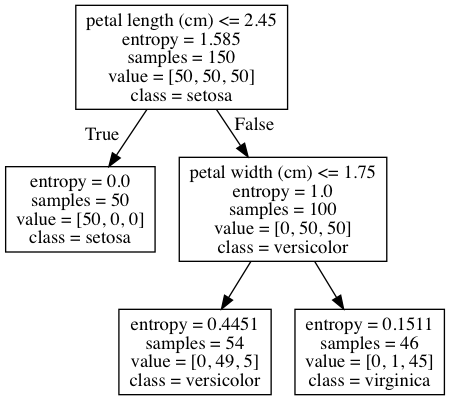

In [14]:
Image("iris.png")

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=0)
train_df = pd.DataFrame(X_train, columns=['length', 'width'])

In [16]:
mytree = DTree(max_depth=2)
b = mytree.fit(train_df, y_train)

In [17]:
# print(json.dumps(b, indent=2, sort_keys=True))